In [1]:
from attridict import AttriDict

TRIGGERS = AttriDict(
    STATEEND=10,
    TRIALEND=11,
    BLOCKEND=12,
    ITI=13,
    FIXATION=14,
    BREAK=15,
    INTERBLOCK=16,
    ABORT=17,
    ERROR=18,
    EXPEND=255,
    # 20-30 are reserved for the query condition
    QUERY=dict(
        TRUE=dict(
            F1LEFT=20,
            F1RIGHT=21,
        ),
        FALSE=dict(
            F1LEFT=22,
            F1RIGHT=23,
        ),
    ),
    # 30-40 are reserved for the two-word stimulus condition
    TWOWORD=dict(
        PHRASE=dict(
            F1LEFT=30,
            F1RIGHT=31,
        ),
        NONPHRASE=dict(
            F1LEFT=32,
            F1RIGHT=33,
        ),
        NONWORD=dict(
            F1LEFT=34,
            F1RIGHT=35,
        ),
    ),
    # 40-50 are reserved for the one-word stimulus condition
    ONEWORD=dict(
        WORD=dict(
            F1=40,
            F2=41,
        ),
        NONWORD=dict(
            F1=42,
            F2=43,
        ),
    ),
)

In [2]:
import mne
import pandas as pd
import numpy as np
from autoreject import AutoReject
from pathlib import Path
from scipy.interpolate import interp1d
from intermodulation.utils import nested_iteritems

mne.set_config("MNE_BROWSER_BACKEND", "matplotlib")
%matplotlib inline

# Load the epoched data
datapath = Path("/home/gercek/scratch/syntax_im/241018/")
rawfile = datapath / "pilot03-cHPI-line-sss-preproc.fif"
events = mne.read_events(datapath / "pilot03-eve.fif")
annot = mne.read_annotations(datapath / "pilot03-badseg-annot.fif")
raw = mne.io.read_raw_fif(rawfile, preload=True)
raw.set_annotations(annot)

Using matplotlib as 2D backend.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc.fif...


/tmp/ipykernel_1014930/4157627658.py:17: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(rawfile, preload=True)


    Range : 19000 ... 1751999 =     19.000 ...  1751.999 secs
Ready.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc-1.fif...
    Range : 1752000 ... 2674999 =   1752.000 ...  2674.999 secs
Ready.
Reading 0 ... 2655999  =      0.000 ...  2655.999 secs...


<Raw | pilot03-cHPI-line-sss-preproc.fif, 326 x 2656000 (2656.0 s), ~6.46 GB, data loaded>

Now that we have discrete epochs, we can look at the raw data to get an idea of artifacts present. We'll first look for low-frequency drifts, which don't appear to be present in the data:

Setting up low-pass filter at 2.4e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 240.00 Hz: -6.02 dB



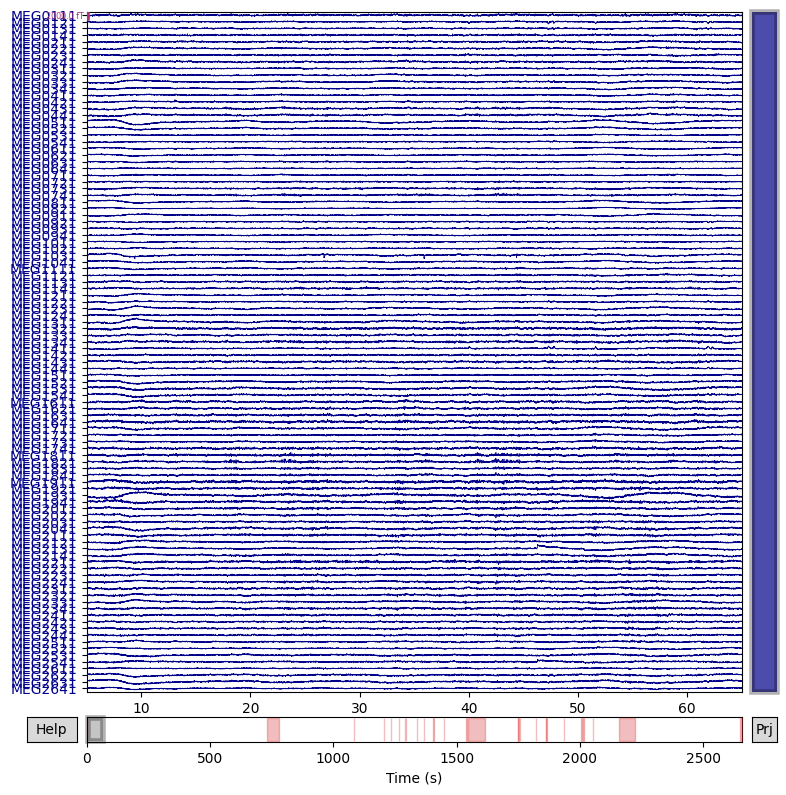

In [2]:
mag_channels = mne.pick_types(raw.info, meg="mag")
fig = raw.plot(
    start=5.0,
    duration=60.0,
    order=mag_channels,
    n_channels=len(mag_channels),
    remove_dc=False,
    use_opengl=True,
    lowpass=240.0,
)

Let's also look at the ICA projections for the first few components while we're at it, for the filtered data. These look good to my naive eye, and don't show any substantial problems:

In [3]:
ica = mne.preprocessing.ICA(n_components=40, random_state=97, max_iter=800)
rawfil = raw.copy().filter(1, 40, n_jobs=-1)
ica.fit(rawfil, reject=None, reject_by_annotation=True)

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 124 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 245 out of 306 | elapsed:    2.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    2.9s finished


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Omitting 213299 of 2656000 (8.03%) samples, retaining 2442701 (91.97%) samples.
Selecting by number: 40 components
Fitting ICA took 222.9s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,68 iterations on raw data (2442701 samples)
ICA components,40
Available PCA components,306
Channel types,"mag, grad"
ICA components marked for exclusion,—


Now let's examine the 1w and 2w task epochs:

In [5]:
import matplotlib.pyplot as plt

plotdir = datapath / "ica_plots"
plotdir.mkdir(exist_ok=True)
for picks in [range(20), range(20, 40)]:
    figs = ica.plot_properties(rawfil, picks=picks, figsize=(5, 6), show=False)
    for i, fig in enumerate(figs):
        fig.savefig(plotdir / f"ica_comp{picks[i]}.png")
        plt.close(fig)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
809 matching events found
No baseline correction applied
0 pro

Creating RawArray with float64 data, n_channels=40, n_times=2656000
    Range : 19000 ... 2674999 =     19.000 ...  2674.999 secs
Ready.


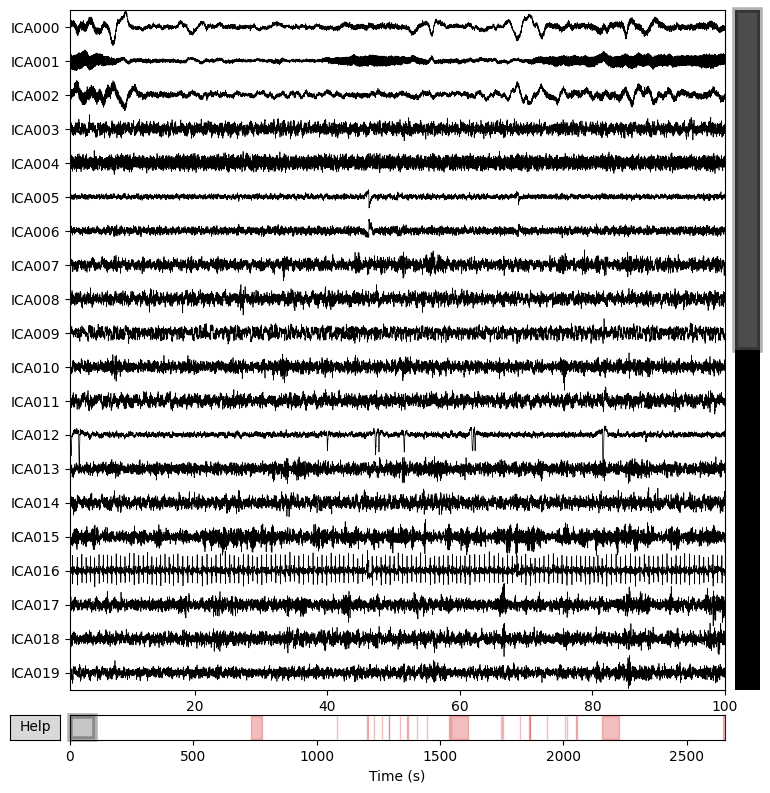

In [7]:
fig = ica.plot_sources(
    rawfil,
    start=1.2,
    stop=100.0,
)

In [8]:
ica.apply(raw, exclude=[5, 6, 16, 12])
ica.save(rawfile.with_name(rawfile.stem + "-ica.fif"))

Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Writing ICA solution to /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-preproc-ica.fif...


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,68 iterations on raw data (2442701 samples)
ICA components,40
Available PCA components,306
Channel types,"mag, grad"
ICA components marked for exclusion,—


Filtering raw data in 6 contiguous segments
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 124 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 245 out of 306 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    2.4s finished


Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 17)
17 projection items activated
Using data from preloaded Raw for 120 events and 2201 original time points ...
2 bad epochs dropped


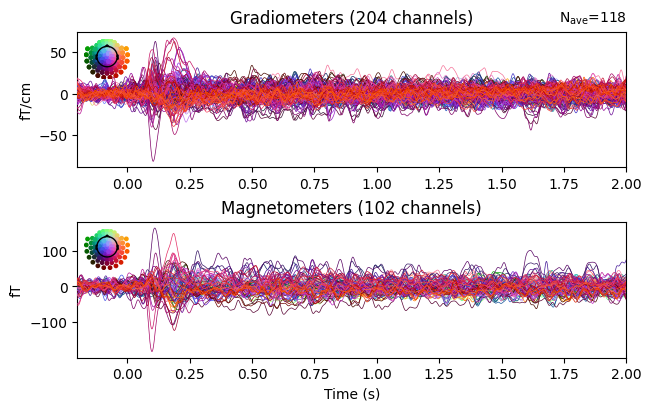

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 124 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 245 out of 306 | elapsed:    6.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    8.3s finished


In [23]:
basebands = {"Beta (12-30 Hz)": (12, 30), "Gamma (30-45 Hz)": (30, 45)}
basebands["Stimulus F1 (20 Hz)"] = (19, 21)
basebands["Stimulus F2 (30 Hz)"] = (29, 31)

ev1w = events[np.isin(events[:, 2], np.arange(40, 51))]
usedtrigs = np.unique(ev1w[:, 2])
triglabels = {"/".join(k): v for k, v in nested_iteritems(TRIGGERS) if v in usedtrigs}
epochs1w = mne.Epochs(
    raw.copy().filter(l_freq=None, h_freq=40, picks="data", n_jobs=-1),
    ev1w,
    event_id=triglabels,
    tmin=-0.2,
    tmax=2.0,
    baseline=(None, 0),
    preload=True,
)
epochs1w.average().plot()
spect1w = epochs1w["F1"].compute_psd(fmax=70, n_jobs=-1)
tfr1w = epochs1w["F1"].compute_tfr(method="morlet", freqs=np.arange(17, 40, 1), n_jobs=-1)

Averaging across epochs before plotting...


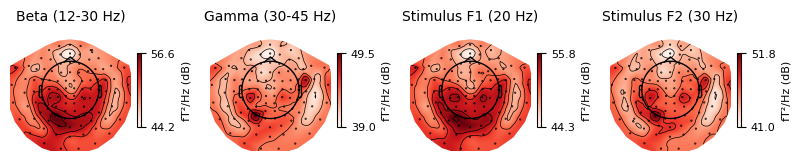

Applying baseline correction (mode: mean)


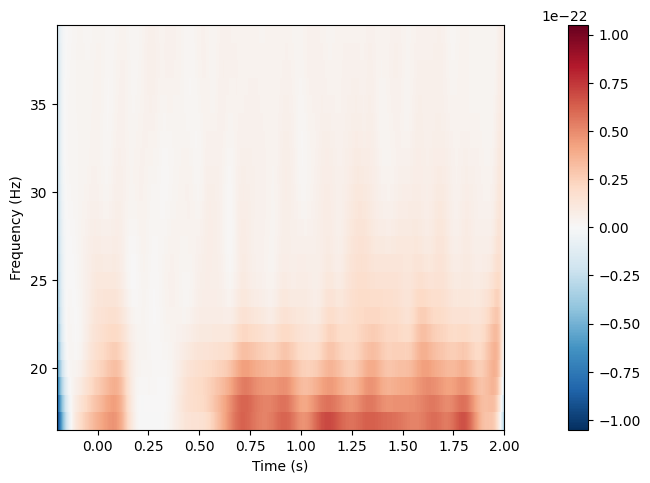

Applying baseline correction (mode: logratio)


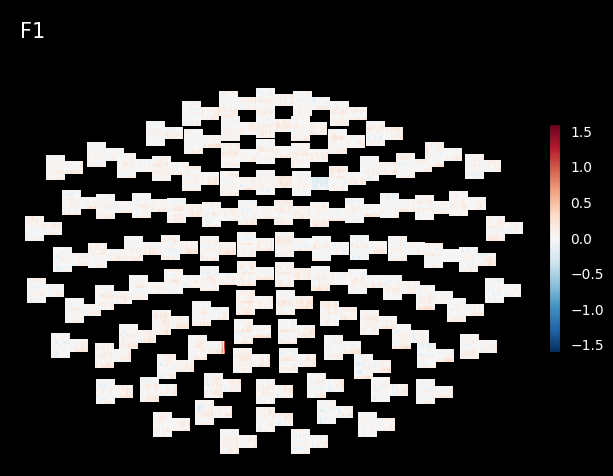

In [24]:
spect1w.plot_topomap(basebands, ch_type="mag", dB=True)
fig1 = tfr1w.average().plot(baseline=(None, 0), combine="mean")
fig = (
    tfr1w.average()
    .plot_topo(
        baseline=(-0.2, 0),
        mode="logratio",
        title="F1",
    )
    .set_size_inches((20, 20))
)

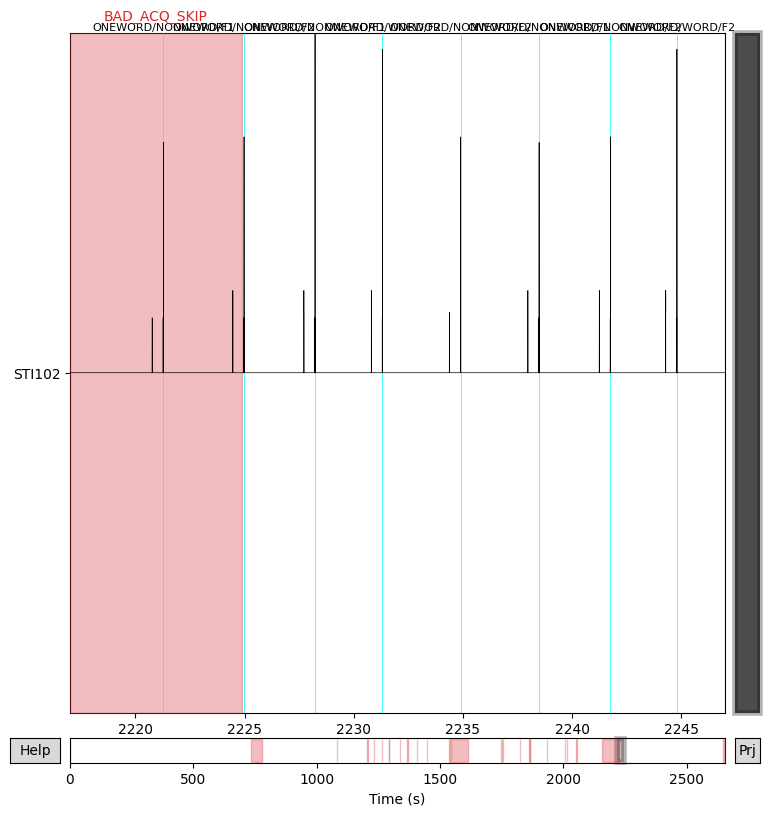

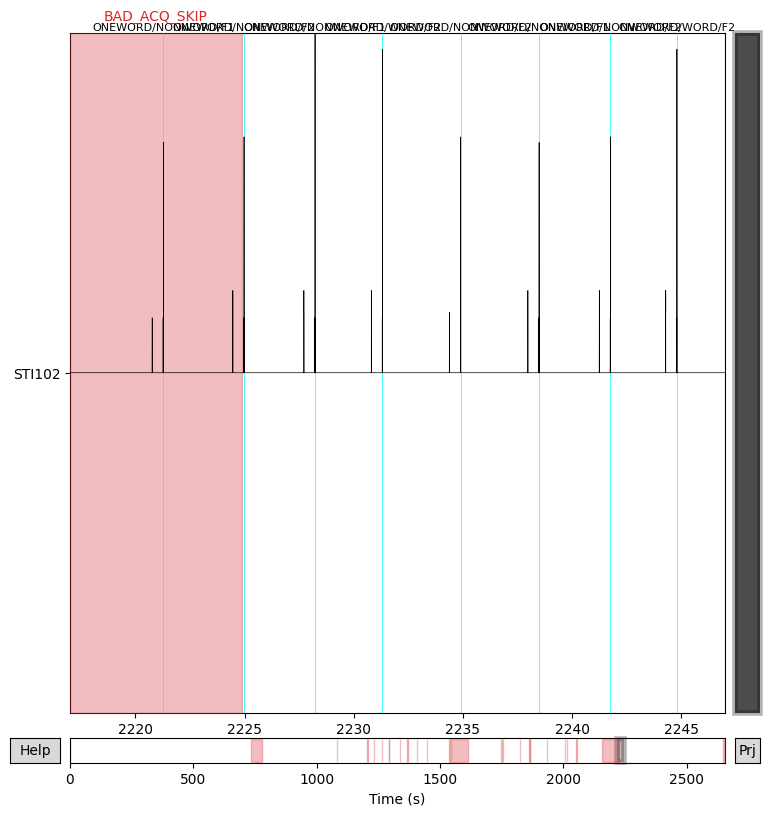

In [26]:
raw.plot(
    picks="STI102",
    events=ev1w[np.isin(ev1w[:, 2], np.arange(40, 50))],
    event_id={k: v for k, v in triglabels.items() if v in np.arange(40, 50)},
    start=2217.0,
    duration=30.0,
    n_channels=20,
    remove_dc=False,
)

In [15]:
from copy import deepcopy

import numpy as np

# from mne import EvokedArray
from mne.evoked import EvokedArray
from mne.source_estimate import SourceEstimate


def psd_z_score(psd, n_bins, mode="z", n_gap=0, minmax=True):
    """Z-score PSD with respect to neighbouring frequency bins.

    Parameters:
    psd: instance of Evoked or SourceEstimate
        The PSD, data of dimension (n_channels, n_freqs).
    n_bins: int
        Number of neighbouring frequency bins to use to compute standard
        deviation. Bins will be taken from each side at each frequency,
        thus altogether 2*n_bins bins will be used.
    mode: str ('z' | 'baseline' | 'snr')
        Whether to do subtract baseline ('baseline'), divide by standard
        deviation ('snr'), or both ('z', first baseline then snr).
        Defaults to 'z'.
    n_gap: int
        Gap between target frequency and neighbouring bins.
    minmax: Bool
        Whether or not to remove minimum and maximum values from z-scoring.
    Returns:
    psd_z: instance of Evoked or SourceEstimate
        The transformed PSD, shape (n_channels, n_freqs).
        'z' subtracts baseline and divides by standard deviation;
        snr' is amplitude divided by standard deviation;
        'baseline' only subtracts baseline.
    """
    # get PSD as numpy array (works for Evoked and SourceEstimate)
    data = psd.data

    # initialise output
    data_z = deepcopy(data)

    # will contain baseline values to be subtracted
    base_mat = np.zeros(data.shape)

    # will contain standard deviation to be divided by
    sd_mat = np.zeros(data.shape)

    # Compute baseline values and standard deviations first as matrices,
    # then subtract/divide on whole matrices
    # hopefully faster

    for ff in np.arange(0, data.shape[1]):  # for frequencies
        # take care of edges in PSD
        m = np.max([0, ff - n_bins - n_gap])
        n = np.min([data.shape[1], ff + 1 + n_bins + n_gap])

        # neighbouring elements before and after this frequency
        base_idx = np.r_[np.arange(m, ff - n_gap), np.arange(ff + 1 + n_gap, n)]

        for cc in np.arange(0, data.shape[0]):  # for channels or vertices
            # get baseline amplitudes
            baseline = data[cc, base_idx]

            # indices of minimum and maximum baseline value
            minidx = baseline.argmin()
            maxidx = baseline.argmax()

            # remove min/max values from baseline
            np.delete(baseline, (minidx, maxidx))

            # avoiding too many comparisons
            if mode == "baseline":
                # average taken later, since always same number of elements
                base_mat[cc, ff] = np.mean(baseline)

            elif mode == "snr":
                sd_mat[cc, ff] = np.std(baseline)

            elif mode == "z":
                base_mat[cc, ff] = np.mean(baseline)

                sd_mat[cc, ff] = np.std(baseline)

    # subtract average of baseline
    if mode in ["z", "baseline"]:
        data_z = data_z - base_mat

    # divided by standard deviation of baseline
    if mode in ["z", "snr"]:
        data_z = data_z / sd_mat

    # put processed data into Evoked or SourceEstimate,
    # depending on input
    if type(psd) is SourceEstimate:
        vertices = [psd.lh_vertno, psd.rh_vertno]

        tmin = psd.times[0]

        if len(psd.times) > 1:
            tstep = psd.times[1] - psd.times[0]

        else:  # in case only one sample present
            tstep = 0.001

        psd_z = SourceEstimate(data=data_z, vertices=vertices, tmin=tmin, tstep=tstep)

    elif type(psd) is EvokedArray:
        tmin = psd.times[0]

        nave = psd.nave

        psd_z = EvokedArray(data_z, psd.info, tmin=tmin, nave=nave)

    else:
        print("Type of " "psd" " not know (%s)" % type(psd))

    return psd_z


In [38]:
evoked = epochs1w["F2"].compute_psd(fmax=70, n_jobs=-1).average()
evokedarr = mne.EvokedArray(evoked.get_data(), evoked.info)
zscev = psd_z_score(evokedarr, 8)

    Using multitaper spectrum estimation with 7 DPSS windows


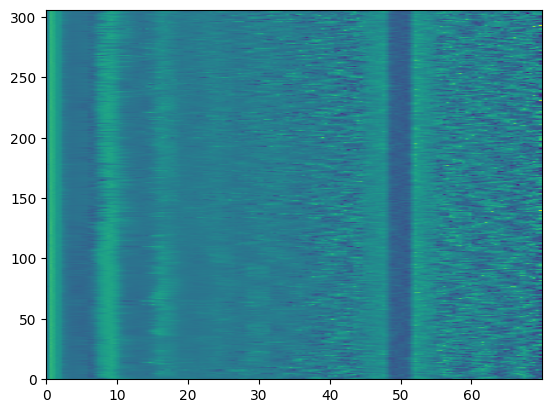

In [39]:
import matplotlib.pyplot as plt

plt.imshow(
    zscev.get_data(),
    extent=(
        0,
        evoked.freqs[-1],
        0,
        evoked.shape[0],
    ),
    aspect="auto",
)

In [34]:
evoked.shape

(306, 155)